# Practical assignment 1
#### Group 8: Christopher Galias (s1009417) and Robin de Heer (s4349792)

A simple multi-layer perceptron with ten nodes in the hidden layer utilized on the MNIST classification task. The code is adapted from the [Chainer Tutorial](https://docs.chainer.org/en/stable/tutorial/basic.html#example-multi-layer-perceptron-on-mnist) and the [CIFAR example](https://github.com/chainer/chainer/blob/master/examples/cifar/train_cifar_custom_loop.py).

First, we import the necessary libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import chainer
from chainer import Variable
from chainer import datasets, iterators, optimizers
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.dataset import convert
from chainer.datasets import TupleDataset

Next, we copy the custom get_mnist() procedure from utils.py.

In [2]:
def get_mnist(n_train=100, n_test=100, n_dim=1, with_label=True, classes=None):
    """

    :param n_train: nr of training examples per class
    :param n_test: nr of test examples per class
    :param n_dim: 1 or 3 (for convolutional input)
    :param with_label: whether or not to also provide labels
    :param classes: if not None, then it selects only those classes, e.g. [0, 1]
    :return:
    """

    train_data, test_data = chainer.datasets.get_mnist(ndim=n_dim, withlabel=with_label)

    if not classes:
        classes = np.arange(10)
    n_classes = len(classes)

    if with_label:

        for d in range(2):

            if d==0:
                data = train_data._datasets[0]
                labels = train_data._datasets[1]
                n = n_train
            else:
                data = test_data._datasets[0]
                labels = test_data._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i==0:
                    idx = lidx
                else:
                    idx = np.hstack([idx,lidx])

            L = np.concatenate([i*np.ones(n) for i in np.arange(n_classes)]).astype('int32')

            if d==0:
                train_data = TupleDataset(data[idx],L)
            else:
                test_data = TupleDataset(data[idx],L)

    else:

        tmp1, tmp2 = chainer.datasets.get_mnist(ndim=n_dim,withlabel=True)

        for d in range(2):

            if d == 0:
                data = train_data
                labels = tmp1._datasets[1]
                n = n_train
            else:
                data = test_data
                labels = tmp2._datasets[1]
                n = n_test

            for i in range(n_classes):
                lidx = np.where(labels == classes[i])[0][:n]
                if i == 0:
                    idx = lidx
                else:
                    idx = np.hstack([idx, lidx])

            if d == 0:
                train_data = data[idx]
            else:
                test_data = data[idx]

    return train_data, test_data

Then we set some hyperparameters we will be using, as per the assignment instructions.

In [3]:
batchsize = 32
n_units = 10
n_epochs = 20

What follows is the definition of the chains our model will be comprised of.

In [4]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
        # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        return self.l2(h)
        
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        return loss

Next, we load the MNIST dataset and create the iterators we will be using.

In [5]:
# train, test = chainer.datasets.get_mnist()
train, test = get_mnist()

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                                             repeat=False, 
                                             shuffle=False)

train_count = len(train)
test_count = len(test)

Then we create the model and setup the optimizer.

In [6]:
model = L.Classifier(MLP(n_units, 10))
    
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)

What follows is the training procedure, which also saves the train/test loss, so we can plot it later. The loss and accuracy are also printed below.

In [7]:
train_losses = []
test_losses = []

sum_accuracy = 0
sum_loss = 0

while train_iter.epoch < n_epochs:
    batch = train_iter.next()

    x_array, t_array = convert.concat_examples(batch, -1)
    x = chainer.Variable(x_array)
    t = chainer.Variable(t_array)
    optimizer.update(model, x, t)
    sum_loss += float(model.loss.data) * len(t.data)
    sum_accuracy += float(model.accuracy.data) * len(t.data)

    if train_iter.is_new_epoch:
        print('epoch: ', train_iter.epoch)
        train_loss = sum_loss / train_count
        train_losses.append(train_loss)
        print('train mean loss: {}, accuracy: {}'.format(
              train_loss, sum_accuracy / train_count))
        
        sum_accuracy = 0
        sum_loss = 0
        model.predictor.train = False
        for batch in test_iter:
            x_array, t_array = convert.concat_examples(batch, -1)
            x = chainer.Variable(x_array)
            t = chainer.Variable(t_array)
            loss = model(x, t)
            sum_loss += float(loss.data) * len(t.data)
            sum_accuracy += float(model.accuracy.data) * len(t.data)

        test_iter.reset()
        model.predictor.train = True
        test_loss = sum_loss / test_count
        test_losses.append(test_loss)
        print('test mean  loss: {}, accuracy: {}'.format(
              test_loss, sum_accuracy / test_count))
        sum_accuracy = 0
        sum_loss = 0

('epoch: ', 1)
train mean loss: 2.34514221954, accuracy: 0.151
test mean  loss: 2.24891267776, accuracy: 0.167
('epoch: ', 2)
train mean loss: 2.19473171234, accuracy: 0.239
test mean  loss: 2.18390218925, accuracy: 0.255
('epoch: ', 3)
train mean loss: 2.11438938904, accuracy: 0.309
test mean  loss: 2.11682729149, accuracy: 0.307
('epoch: ', 4)
train mean loss: 2.02911248779, accuracy: 0.352
test mean  loss: 2.03869499016, accuracy: 0.342
('epoch: ', 5)
train mean loss: 1.99552161407, accuracy: 0.418
test mean  loss: 1.95383088875, accuracy: 0.381
('epoch: ', 6)
train mean loss: 1.84086058426, accuracy: 0.439
test mean  loss: 1.87716124535, accuracy: 0.398
('epoch: ', 7)
train mean loss: 1.75388817215, accuracy: 0.482
test mean  loss: 1.8054261446, accuracy: 0.422
('epoch: ', 8)
train mean loss: 1.66942145538, accuracy: 0.502
test mean  loss: 1.73866480827, accuracy: 0.433
('epoch: ', 9)
train mean loss: 1.63891329193, accuracy: 0.557
test mean  loss: 1.6715147543, accuracy: 0.452
('e

Finally, we plot the test/train loss with regards to the number of epochs. We can see the model overfitting a bit towards the end of the training procedure.

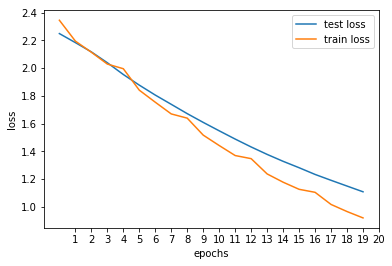

In [8]:
plt.plot(test_losses)
plt.plot(train_losses)

plt.legend(["test loss", "train loss"])
plt.ylabel("loss")
plt.xlabel("epochs")

# to enforce integer xticks
eps = np.linspace(1, n_epochs, n_epochs)
_ = plt.xticks(eps)